Let's learn PCA and how to visualize data!!!

# Defining the dataset

In [ ]:
# Load the dataset.
import scipy.io
mat = scipy.io.loadmat('../data/Data_All_Jul25.mat')
data = mat['ans']

In [ ]:
# Define which frequencies and indices we want to get get.
frequencies = ['f500', 'f1000', 'f2000', 'f3000', 'f4000', 'f6000']
ears = ['right', 'left']
indices = range(0, len(data[0]))

In [ ]:
# For the sake of quicker access. Let's just grab the values from the struct and put it into a dataframe.
import pandas as pd
import math

ids = []

# Iterate through all participants
for index in indices:

	# Access the data from the struct
	if not math.isnan(data[0][index][0][0][0]):
		id = int(data[0][index][0][0][0])
		ids.append(id)


In [47]:
# Initialize a df
df = pd.DataFrame({
	'ID' : [id for id in ids]
})
# To access a participant ID row, do this: df.loc[df['ID'] == id, 'column']

In [ ]:
# Initialize columns
columns = []
for ear in ears:
	for frequency in frequencies:
		column = ear + '_' + frequency
		columns.append(column)
		df[column] = [0 for _ in range(len(df['ID']))]
		print(f"Column added: {column}")

In [65]:
df

,ID,right_f500,right_f1000,right_f2000,right_f3000,right_f4000,right_f6000,left_f500,left_f1000,left_f2000,left_f3000,left_f4000,left_f6000
0,1003,0,0,0,0,0,0,0,0,0,0,0,0
1,1004,0,0,0,0,0,0,0,0,0,0,0,0
2,1005,0,0,0,0,0,0,0,0,0,0,0,0
3,1006,0,0,0,0,0,0,0,0,0,0,0,0
4,1008,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,3094,0,0,0,0,0,0,0,0,0,0,0,0
186,3095,0,0,0,0,0,0,0,0,0,0,0,0
187,3100,0,0,0,0,0,0,0,0,0,0,0,0
188,3114,0,0,0,0,0,0,0,0,0,0,0,0


In [72]:
# Get the actual values into the df
for index in indices:
	if not math.isnan(data[0][index][0][0][0]):
		id = int(data[0][index][0][0][0])
		for ear in ears:
			for frequency in frequencies:
					dBHL = data[0][index]['aud']['audiogram'][0][0]['ac'][0][0][ear][0][0][frequency][0][0][0][0]
					column = ear + '_' + frequency
					df.loc[df['ID'] == id, column] = dBHL

In [24]:
# Let's also include some information regarding their classification labels. We can always remove them if we don't want them!

# I already have the labels in this path.
labels_df = pd.read_excel('struct_labels.xlsx')

# Initialize some columns
df['Military Profile'] = pd.Series(dtype='str')
df['Clinical Profile'] = pd.Series(dtype='str')

In [ ]:
# Get the corresponding labels
for index, row in labels_df.iterrows():
	id = row['ID']
	military_profile = row['Military Profile']
	clinical_profile = row['Clinical Profile']
	df.loc[df['ID'] == id, 'Military Profile'] = military_profile
	df.loc[df['ID'] == id, 'Clinical Profile'] = clinical_profile

In [82]:
# For the sake of PCA, let's drop na values
df = df.dropna()

In [ ]:
# Save this dataframe.
df.to_csv('dBHL.csv')

# PCA!

In [1]:
# Import our data
import pandas as pd
df = pd.read_csv('dBHL.csv')
df = df.drop(columns=['Unnamed: 0'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                188 non-null    int64  
 1   right_f500        188 non-null    float64
 2   right_f1000       188 non-null    float64
 3   right_f2000       188 non-null    float64
 4   right_f3000       188 non-null    float64
 5   right_f4000       188 non-null    float64
 6   right_f6000       188 non-null    float64
 7   left_f500         188 non-null    float64
 8   left_f1000        188 non-null    float64
 9   left_f2000        188 non-null    float64
 10  left_f3000        188 non-null    float64
 11  left_f4000        188 non-null    float64
 12  left_f6000        188 non-null    float64
 13  Military Profile  188 non-null    object 
 14  Clinical Profile  188 non-null    object 
dtypes: float64(12), int64(1), object(2)
memory usage: 22.2+ KB


In [2]:
# Just one change. Let's limit our PCA to only the first visit.
# We can looking at second and third visits later.
for index, row in df.iterrows():
	if row['ID'] > 1999: # Detect second visit
		first_visit_df = df.drop(range(index, len(df)))
		break
len(first_visit_df)

140

In [3]:
# Libraries needed for PCA
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [4]:
# Define our dataset of frequency values & participant ID as the index.
data = first_visit_df.drop(columns=['ID', 'Military Profile', 'Clinical Profile'])
data = data.set_index(first_visit_df['ID'])

In [ ]:
# Centering and scaling the data
scaled_data = preprocessing.scale(data) # .T transposed might be needed because scale function expects samples (participants) to be in rows.

# Centering: Makes average 0
# Scaling: SD is 1

In [44]:
pca = PCA()
pca.fit(scaled_data) # Fit data
pca_data = pca.transform(scaled_data) # Generate coordinates for graph

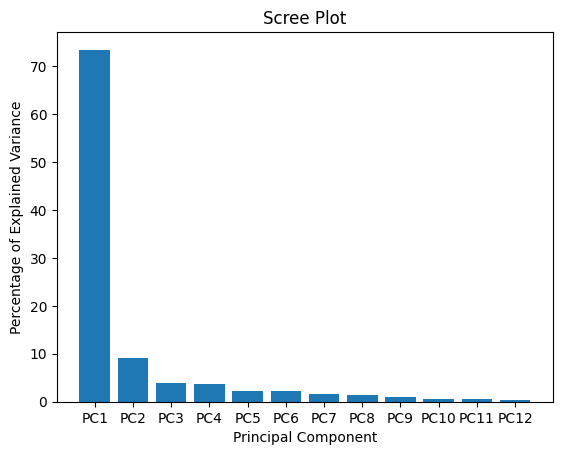

In [45]:
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range (1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

Looks like PC1 has just a bit above 70% of the variance, with a large gap between PC1 and PC2. This is good for a 2D graph.

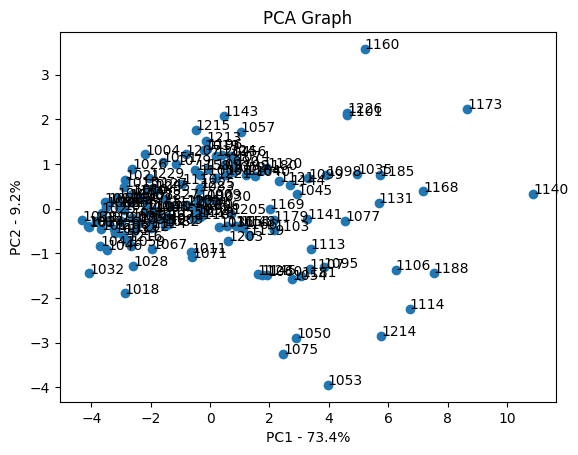

In [46]:
pca_df = pd.DataFrame(pca_data, index=[index for index, __ in data.iterrows()], columns=labels)
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('PCA Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

for sample in pca_df.index:
	plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))

plt.show()

Essentially, by doing PCA, we're looking at the dimensions that give us the highest amount of variance. Doing so, we're able to capture as much variance as possible within this 2-dimensional space.

Now, we'll look at the clusters using K-means

In [47]:
import seaborn as sns
from sklearn.cluster import KMeans

In [48]:
four_kmeans = KMeans(n_clusters=4).fit(scaled_data)  # For now, we'll do n_clusters as 3 (clinical) and 4 (military)
three_kmeans = KMeans(n_clusters=3).fit(scaled_data)
pca_df['four clusters'] = pd.Categorical(four_kmeans.labels_)
pca_df['three clusters'] = pd.Categorical(three_kmeans.labels_)

<Axes: xlabel='PC1', ylabel='PC2'>

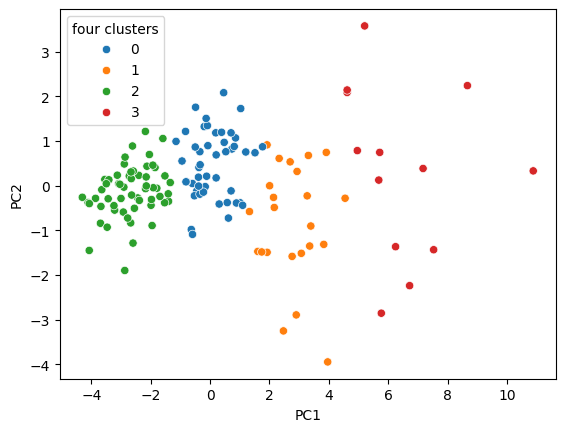

In [49]:
sns.scatterplot(x="PC1",y="PC2",hue="four clusters",data=pca_df)

<Axes: xlabel='PC1', ylabel='PC2'>

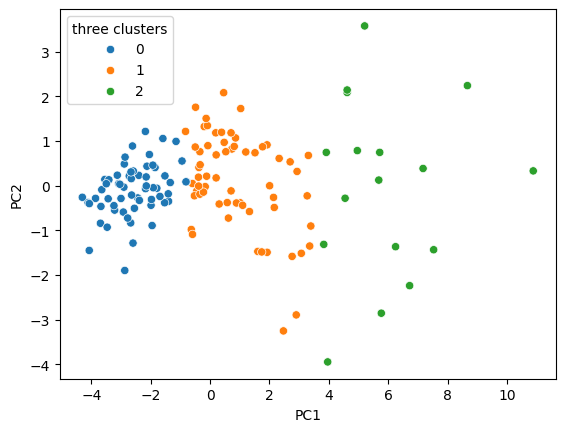

In [ ]:
sns.scatterplot(x="PC1",y="PC2",hue="three clusters",data=pca_df)

In [ ]:
# Let's look at the silhouette scores to fine-tune how many "K" points we should use.
from sklearn.metrics import silhouette_score
fine_tune_kmeans = KMeans(n_clusters=2)
silhouette_score(scaled_data, fine_tune_kmeans.fit_predict(scaled_data)) # We're looking for a score above 70%

np.float64(0.4605817389514782)

- 4 clusters produced 0.31
- 3 clusters produced 0.33
- 2 clusters produced 0.46 (best)

One caveat is that it's harder to get higher silhouette scores in higher dimensional data (we're technically looking at 2 dimensions with PCA, but this data set is 12 dimensions)

Seems like 4 is the magic number (atleast visually it does). Let's compare the clusters that PCA produces to the labels that military and clinical classifiers produce.

In [52]:
# Append our labels onto this df.
pca_df['Military Profile'] = np.array(first_visit_df['Military Profile'])
pca_df['Clinical Profile'] = np.array(first_visit_df['Clinical Profile'])

In [ ]:
import pandas as pd
df = pd.read_csv('dBHL.csv')

# 1st run PCA + K-Means clustering plots

<Axes: xlabel='PC1', ylabel='PC2'>

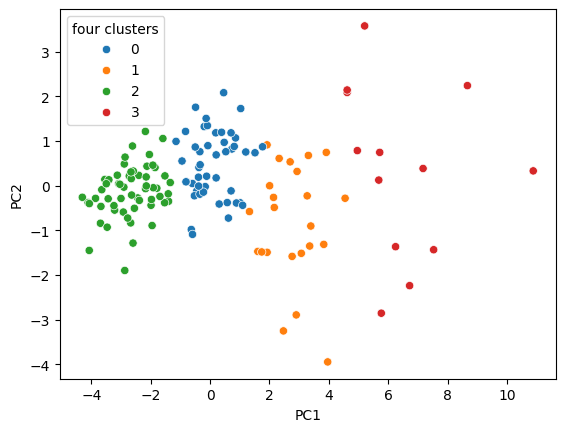

In [61]:
sns.scatterplot(x="PC1",y="PC2",hue="four clusters",data=pca_df) # 4 clusters

<Axes: xlabel='PC1', ylabel='PC2'>

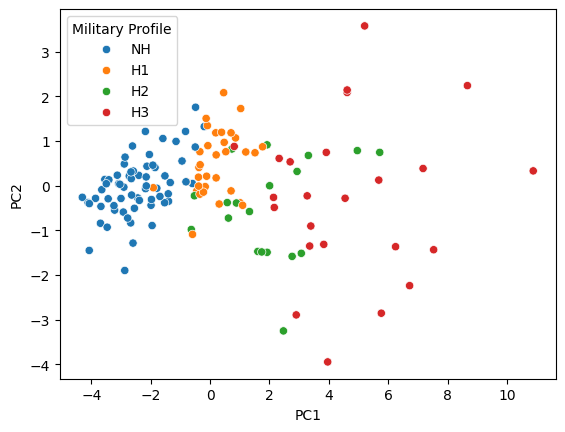

In [62]:
sns.scatterplot(x="PC1",y="PC2",hue="Military Profile",data=pca_df) # Military classification (4 classes)

<Axes: xlabel='PC1', ylabel='PC2'>

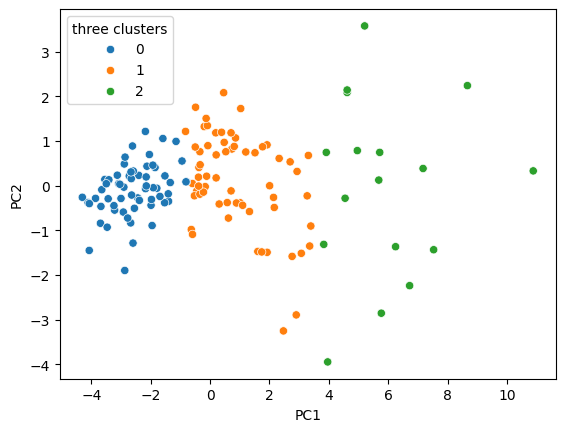

In [63]:
sns.scatterplot(x="PC1",y="PC2",hue="three clusters",data=pca_df) # 3 clusters

<Axes: xlabel='PC1', ylabel='PC2'>

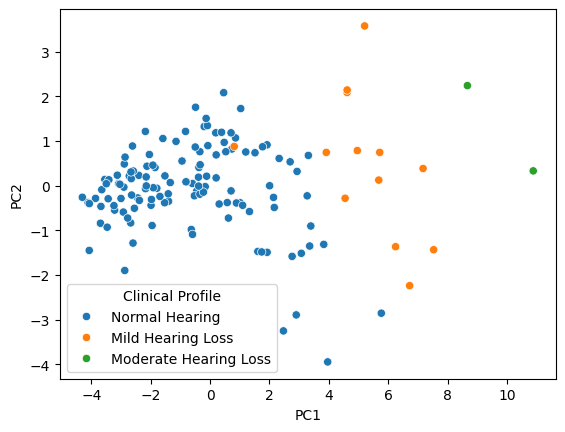

In [64]:
sns.scatterplot(x="PC1",y="PC2",hue="Clinical Profile",data=pca_df) # Clinical classification (3 classes)

Let's explore how similar these classifications are. 

In [59]:
# Visually, this is how these classes align
three_clusters_dict = {0: 'Normal Hearing', 1: 'Normal Hearing', 2: 'Mild Hearing Loss'} 
four_clusters_dict = {0: 'H1', 1: 'H2', 2: 'NH', 3: 'H3'} 

In [ ]:
# Rename to the corresponding label
pca_df['four clusters'].replace(four_clusters_dict, inplace=True)
pca_df['three clusters'].replace(three_clusters_dict, inplace=True) # (Ignore the following warnings)

Now let's see how similar these two graphs are.

In [71]:
def check_accuracy(list1: pd.core.series.Series, list2: pd.core.series.Series):
	total = 0
	same = 0
	different = 0
	if len(list1) != len(list2):
		print("Sizes must be the same")
		return
	for item1, item2 in zip(list1, list2):
		if item1 == item2:
			same += 1
		else:
			different += 1
		total += 1
	print(f"Similarity: {same/total} percent")
	return

In [72]:
check_accuracy(pca_df['four clusters'], pca_df['Military Profile'])

Similarity: 0.7857142857142857 percent


In [73]:
check_accuracy(pca_df['three clusters'], pca_df['Clinical Profile'])

Similarity: 0.9571428571428572 percent


One last caveat: Our PCA was done on the frequencies 500-6000hz, which is consistent with how Military hearing level profiles are categorized. However, Clinical profiles only use 500-2000hz. 

# PCA functions

In [1]:
# Loading the data
import pandas as pd
import numpy as np

def load_data(path): # = '../data/DOD_clinical_data.xlsx'
	xlsx = pd.ExcelFile(path)
	data = {}
	for sheetname in xlsx.sheet_names:
		sheet = pd.read_excel(xlsx, sheet_name=sheetname)
		data[sheetname] = sheet
	return data

In [8]:
!pip install mpl_axes_aligner openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]━━ 1/2 [openpyxl]


In [3]:
# PCA
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pprint
import mpl_axes_aligner

def principal_component_analysis(dataframe: pd.DataFrame, columns: list[str], n_components: int): 
	"""
	Params:
	- dataframe: A dataframe containing all the samples (participants) as rows and the indexes being the ID.
	- columns: A list of strings that are the columns in dataframe. They must be valid columns in the dataframe.
	- n_components: Number of components to pass into PCA. If you don't know, just use the # of columns as your n_components.
	"""
	print("\n --- START PCA ---\n")

	# Shaping our data for PCA
	data = dataframe[columns]
	for column in columns:
		data = data[pd.to_numeric(data[column], errors='coerce').notnull()] # Removes all non-numeric rows
	scaled_data = preprocessing.scale(data) # Centering makes the average 0. Scaling makes the standard deviation 1.

	# Input data into PCA
	pca = PCA(n_components=n_components)
	pca.fit(scaled_data) # Fit data
	pca_data = pca.transform(scaled_data) # Generate coordinates for graph

	# Look at the variance in each PC and plot
	per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
	labels = ['PC' + str(x) for x in range (1, len(per_var)+1)]

	# Check loading scores
	loading_score = pd.DataFrame(pca.components_.T, columns=labels, index=columns)
	# print("\n All loading scores\n")
	# pprint.pprint(loading_score)

	# Scree plot
	plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
	plt.ylabel('Percentage of Explained Variance')
	plt.xlabel('Principal Component')
	plt.title('Scree Plot')
	plt.show()

	# Label each data point in the 2 axes
	fig,ax = plt.subplots(figsize=(15,8))
	pca_df = pd.DataFrame(pca_data, index=[index for index, __ in data.iterrows()], columns=labels)
	ax.scatter(pca_df.PC1, pca_df.PC2)
	ax.set_title('PCA Graph')
	ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
	ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
	for sample in pca_df.index:
		ax.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
	# Plot loadings on this same graph. https://insidelearningmachines.com/biplot/
	ax2 = ax.twinx().twiny()
	font = {'color':  'g',
		'weight': 'bold',
		'size': 12,
		}
	for col in loading_score.T.columns.values:
		tipx = loading_score.T.loc['PC1',col]
		tipy = loading_score.T.loc['PC2',col]
		ax2.arrow(0, 0, tipx, tipy, color = 'r', alpha = 0.5)
		ax2.text(tipx, tipy, col, fontdict = font, ha = 'center', va = 'center')
	mpl_axes_aligner.align.xaxes(ax, 0, ax2, 0, 0.5)
	mpl_axes_aligner.align.yaxes(ax, 0, ax2, 0, 0.5)
	plt.show()

	# Let's focus on the PC's that explain 90-95% of the data
	threshold = 0.95
	loading_tables = []
	total_variance = 0.0
	pc_index = 0
	while total_variance < threshold and pc_index < len(pca.explained_variance_ratio_):

		# Update variance tracker
		total_variance += pca.explained_variance_ratio_[pc_index]

		# Sort the respective PC based off of loadings
		sorted = loading_score.iloc[:, pc_index].copy()
		sorted = sorted.reindex(sorted.abs().sort_values(ascending=False).index)
		sorted = sorted.reset_index().rename(columns={'index': f'PCA{pc_index+1}_index'})
		
		# Save and move on to the next
		loading_tables.append(sorted)
		pc_index += 1

	# Combine into 1 giant DF
	all_dfs = pd.concat(loading_tables, axis=1)
	print(f"\n {pc_index} PCs needed in order to explain {threshold*100}% variation\n")
	pprint.pprint(all_dfs)

	# Append PCA information
	labels = pd.read_excel('../data/DOD_clinical_labels_from_excel.xlsx')
	pca_df['Clinical Profile'] = ['' for _ in range(len(pca_df))]
	pca_df['Military Profile'] = ['' for _ in range(len(pca_df))]
	for index, row in pca_df.iterrows():
		id_val = index
		clinical_match = labels.loc[labels['ID'] == id_val, 'Clinical Profile']
		military_match = labels.loc[labels['ID'] == id_val, 'Military Profile']
		if not clinical_match.empty:
			pca_df.at[index, 'Clinical Profile'] = clinical_match.iloc[0]
		if not military_match.empty:
			pca_df.at[index, 'Military Profile'] = military_match.iloc[0]
	
	print("\n --- END PCA ---\n")
	# Return data for K-Means clustering
	return scaled_data, pca_df
		

In [4]:
# K-means
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import contextlib
import io

# Inputting into K means
def k_means_clustering(k: int, scaled_data, pca_df, tuning=False):
	"""
	Params:
	- k: Number of clusters
	- scaled_data: Scaled data scaled after PCA function
	- pca_df: Dataframe after PCA function
	"""

	if not tuning:
		print(f"\n --- START K-MEANS {k} clusters ---\n")

	# Fit into KMeans object
	some_kmeans = KMeans(n_clusters=k).fit(scaled_data)

	# Input into pca_df
	name = f'{k} clusters'
	pca_df[name] = pd.Categorical(some_kmeans.labels_)

	# Plot colors of clusters
	if not tuning:
		sns.scatterplot(x="PC1",y="PC2",hue=name,data=pca_df)

	# Silhouette score
	fine_tune_kmeans = KMeans(n_clusters=k)
	score = silhouette_score(scaled_data, fine_tune_kmeans.fit_predict(scaled_data)) # We're looking for a score above 70%
	if not tuning:
		print(f"Silhouette score: {score}")
	if not tuning:
		print(f"\n --- END K-MEANS {k} clusters ---\n")

	# Output new pca_df with score
	return pca_df, score

# Tuning for best K-means
def k_means_tuning(k_range, scaled_data, pca_df):
	"""
	Params:
	- k_range: For our use case, probably just range(2, 8). Lower bound must be 2 or else clustering is kind of useless
	- scaled_data: Same as before
	- pca_df: Same as before
	"""

	print(f"\n --- START K-MEANS TUNING ---\n")

	# Iterate through all K in that range
	results = []
	for k in k_range:
		_, score = k_means_clustering(k, scaled_data.copy(), pca_df.copy(), tuning=True)
		results.append((k,score))

	# Find the highest score
	scores_df = pd.DataFrame(results, columns=['k', 'silhouette_score'])
	best_idx = scores_df['silhouette_score'].idxmax()
	best_k = scores_df.loc[best_idx, 'k']
	best_score = scores_df.loc[best_idx, 'silhouette_score']
	print(f"Best k: {best_k}")
	print(f"Best score: {best_score}")
	print(f"\n --- END K-MEANS TUNING ---\n")
	
	# Output best scores
	return best_k, best_score
	

In [5]:
# Show the PCA graph with the colors of the clinical & military profiles
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

def graph_classification(pca_df):
    """
    Params:
    - pca_df: must have "Clinical Profile" and "Military Profile" columns
    """

    # Plot Clinical Profile
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="PC1", y="PC2", hue="Clinical Profile", data=pca_df)
    plt.title("PCA - Clinical Profile")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Plot Military Profile
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="PC1", y="PC2", hue="Military Profile", data=pca_df)
    plt.title("PCA - Military Profile")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
	

In [6]:
# Grab the average between a left and right column
def average_columns(left_column, right_column):
	"""
	Example usage:
	test_df['PTA_A'] = average_columns(test_df['PTA_A_L'], test_df['PTA_A_R'])
	"""
	averages = []
	for left, right in zip(left_column.values, right_column.values):
		average = 0
		if left == None and right == None:
			average = None
		elif left == None:
			average = right
		elif right == None:
			average = left
		else:
			average = (float(left) + float(right))/2
		averages.append(average)
	return averages


# Finding salient variables with PCA.

PCA review:
- PC's are ranked by the amount of variability they capture.
- PC's are a linear combination of the variables in your dataset.
	- The coefficients of the linear combinations are called "loadings"

Loading notes:
- The sign tells you whether the INCLUSION (+) or ABSENSE (-) of it contributes to the PC.
- The mangitude tells you how much the inclusion/absense of it contributes (higher = more contribution).

For now, we can look at which variables are informative or redundant. Here are some notes:
- Variables that contribute heavily to the same PC are likely redundant (PCA combines them into the same signal)
- Variables that contribute across many components are important and complex
- Variables with low contributions across many components are probably uninformative

Furthermore, loading plots will tell us information about variables
- Variables grouped together will be positively correlated (tendency to change the same way, but is it safe to call this redundant?)
- Variables opposite to each other w/ respect to the origin are negatively correlated 
- Variables farther to the origin are "stronger" / more influential.

PCA summarizes: Trends, jumps, clusters, and outliers

# AirCon & AirConHigh sheets

Final data length: 162

 --- START PCA ---



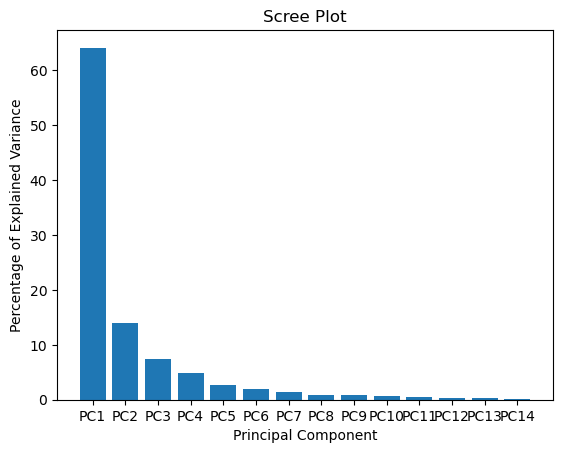

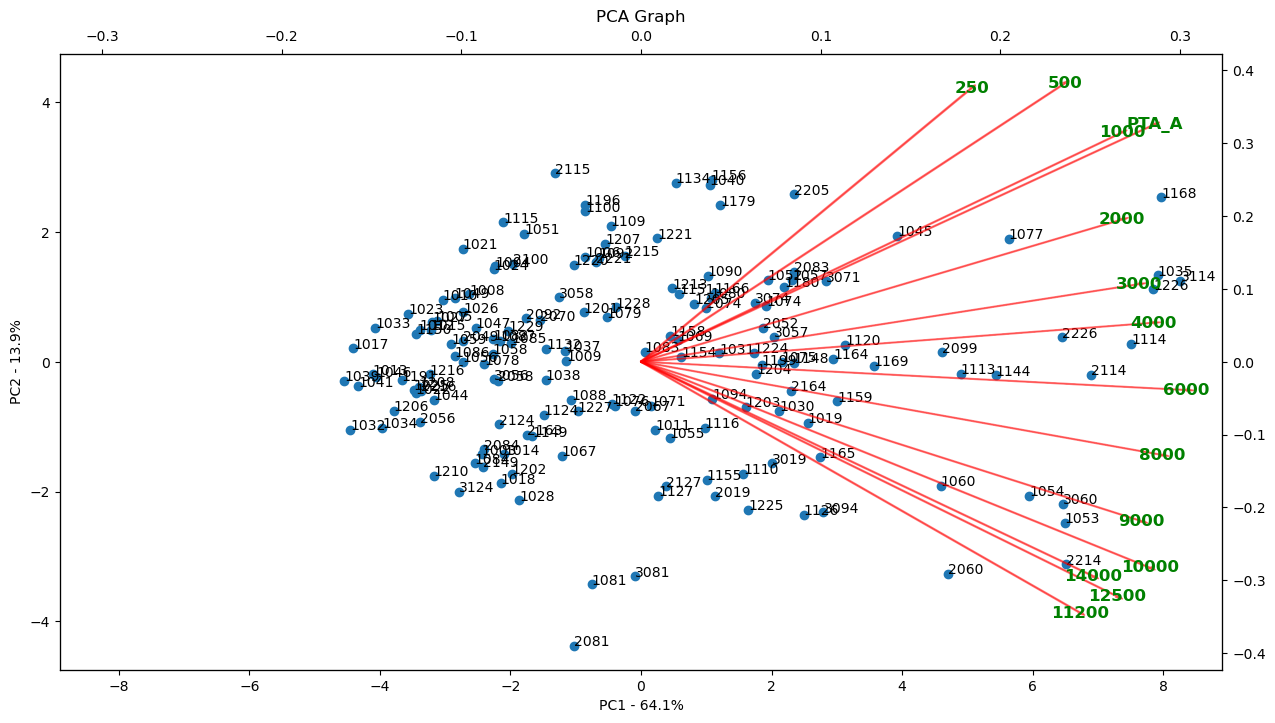


 7 PCs needed in order to explain 95.0% variation

   PCA1_index       PC1 PCA2_index       PC2 PCA3_index       PC3 PCA4_index  \
0        6000  0.303604        500  0.382273       3000  0.411979        250   
1        8000  0.289953        250  0.376126       4000  0.392512       2000   
2       PTA_A  0.285699      11200 -0.344571        250 -0.385076       9000   
3        4000  0.285056      PTA_A  0.325660        500 -0.357553      14000   
4       10000  0.283064      12500 -0.322344      12500 -0.296791       8000   
5        9000  0.278552       1000  0.314608      11200 -0.280791       1000   
6        3000  0.277131      14000 -0.294538       6000  0.268862      12500   
7        2000  0.267767      10000 -0.282644      14000 -0.249986      PTA_A   
8        1000  0.267626       9000 -0.218818       8000  0.234705       6000   
9       12500  0.265229       2000  0.195259       2000  0.128925        500   
10      14000  0.251802       8000 -0.127948      10000 -0.100677   

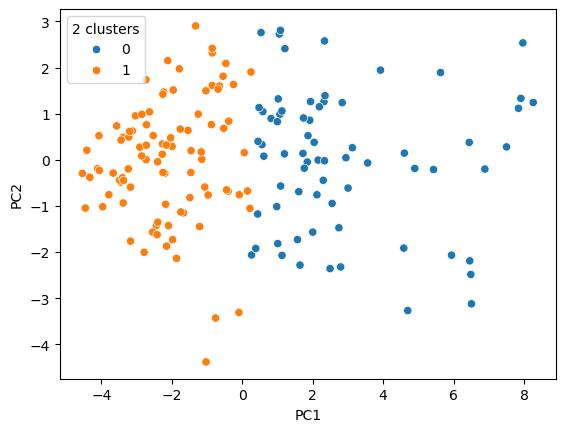

In [9]:
# Grab data and combinedata/DOD_clinical_data.xlsx
data = load_data('../data/DOD_clinical_data.xlsx')
aircon_low_df = data['AirCon'].set_index(data['AirCon']['ID'])
aircon_high_df = data['AirConHigh'].set_index(data['AirCon']['ID']).drop(columns=['RU8000', 'LU8000']) # Redundant info
aircon_all = pd.concat([aircon_low_df, aircon_high_df], axis = 1)

# Clean data
# Note: If we removed all participants that had a DNC or NR reading, we will have 19 participants left. 
# Therefore, a better solution is to exclude the higher frequencies which have a whole lot more of those values.
aircon_all_cleaned = aircon_all.replace({"DNC" : None, "NR" : None})
aircon_all_cleaned.drop(columns=['RU16000', 'RU18000', 'RU20000', 'LU16000', 'LU18000', 'LU20000'], inplace=True)
aircon_all_cleaned.dropna(inplace=True) # Final length is 162

# Average between left and right
aircon_all_averaged = aircon_all_cleaned.copy()
for column in aircon_all_averaged: 
	if 'RU' in column:
		right, frequency = column.split('U')
		aircon_all_averaged[frequency] = average_columns(aircon_all_averaged[column], aircon_all_averaged['LU'+str(frequency)])
aircon_all_averaged['PTA_A'] = average_columns(aircon_all_averaged['PTA_A_R'], aircon_all_averaged['PTA_A_L'])

# Drop the original columns, leaving just the averages
aircon_all_final = aircon_all_averaged.drop(columns=[*aircon_all_cleaned.columns])
print(f"Final data length: {len(aircon_all_final)}")

# PCA call on all AirCon data
scaled_data, pca_df = principal_component_analysis(dataframe=aircon_all_final, 
												   columns=aircon_all_final.columns, 
												   n_components=len(aircon_all_final.columns))
new_pca, score = k_means_clustering(k=2, 
									scaled_data=scaled_data, 
									pca_df=pca_df)
best_k, best_score = k_means_tuning(range(2, 8), 
									scaled_data, 
									pca_df)	

# BoneCon (NEW)

Final data length: 151

 --- START PCA ---



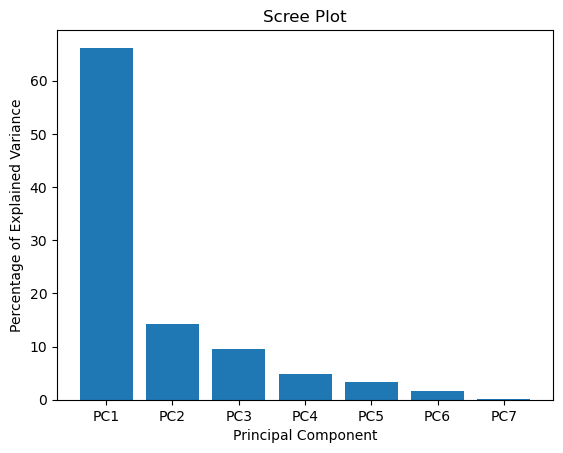

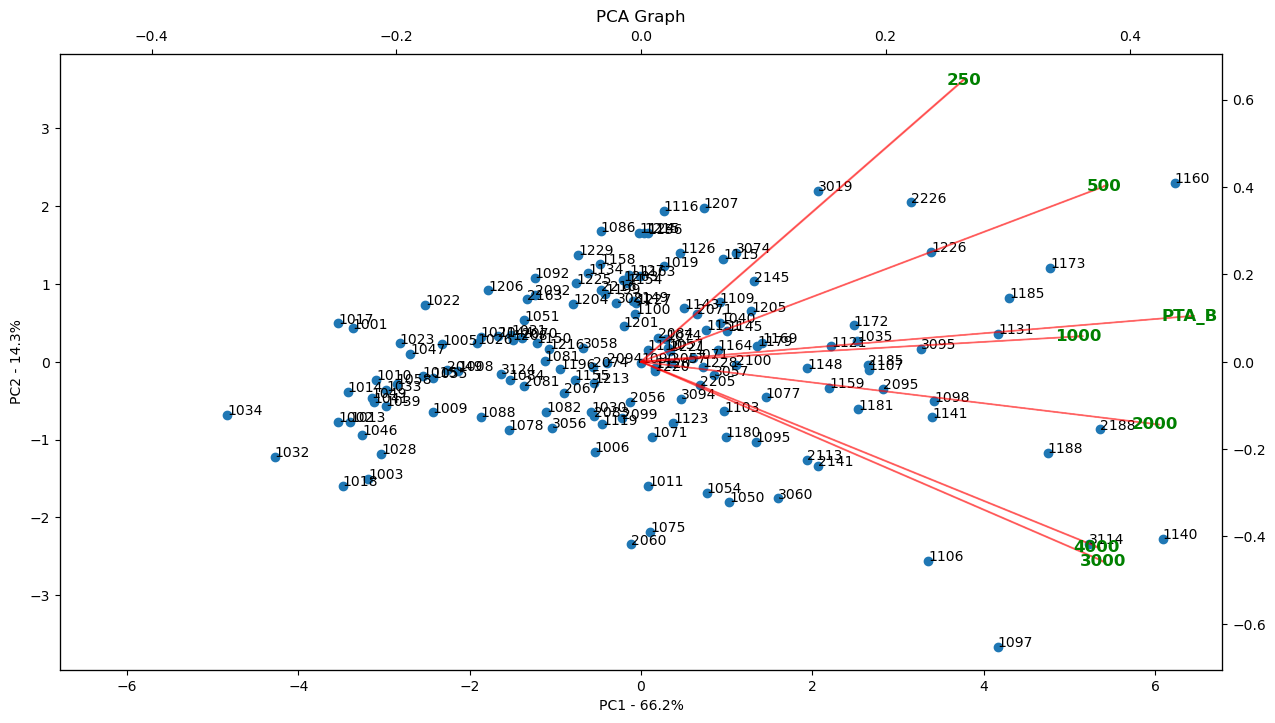


 5 PCs needed in order to explain 95.0% variation

  PCA1_index       PC1 PCA2_index       PC2 PCA3_index       PC3 PCA4_index  \
0      PTA_B  0.448271        250  0.645393       1000  0.649075        500   
1       2000  0.420245       3000 -0.456204        250 -0.525876       1000   
2        500  0.379094       4000 -0.423514       4000 -0.359829        250   
3       3000  0.377468        500  0.401787       3000 -0.313484       2000   
4       4000  0.372752       2000 -0.142622      PTA_B  0.243727      PTA_B   
5       1000  0.357327      PTA_B  0.104204       2000  0.122433       4000   
6        250  0.263868       1000  0.057870        500 -0.003749       3000   

        PC4 PCA5_index       PC5  
0  0.597432       2000  0.705018  
1 -0.576312       4000 -0.452835  
2 -0.438543        500 -0.451042  
3  0.264211        250  0.207919  
4  0.152171       1000 -0.200088  
5 -0.127843       3000  0.085666  
6 -0.096503      PTA_B  0.062016  

 --- END PCA ---


 --- START K-ME

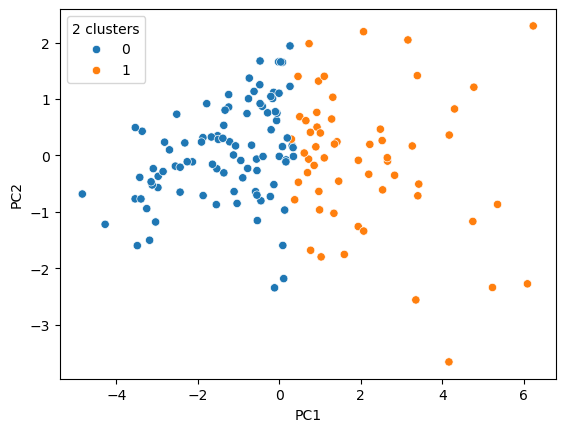

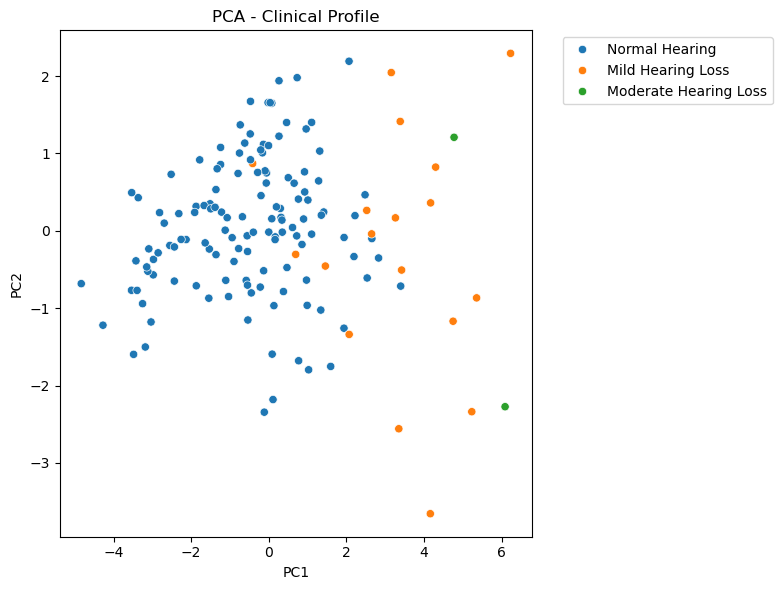

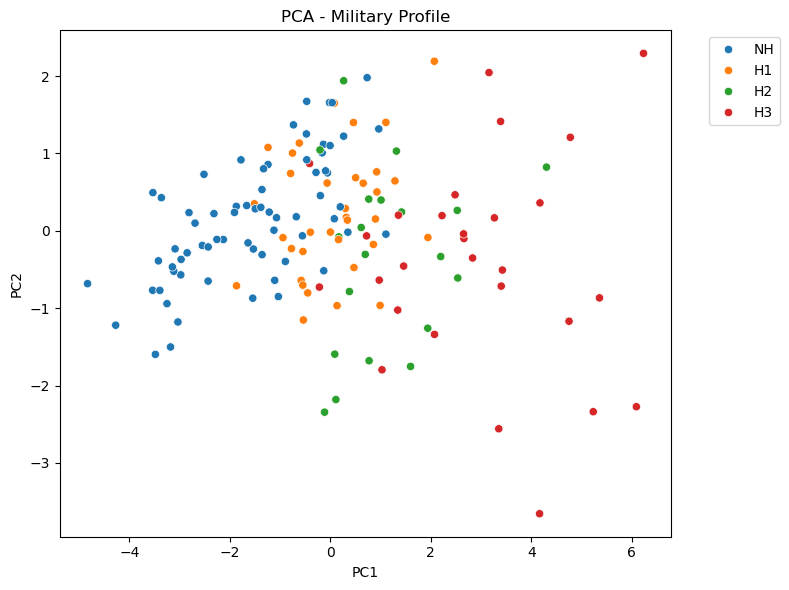

In [10]:
# Grab data and combine
data = load_data('../data/DOD_clinical_data.xlsx')
bonecon = data['BoneCon']

# Clean data
keep = 'PTA_B_R	PTA_B_L	RU250	RU500	RU1000	RU2000	RU3000	RU4000	RU6000	RU8000	LU250	LU500	LU1000	LU2000	LU3000	LU4000	LU6000	LU8000'.split('\t')
bonecon_cleaned = bonecon.replace({"DNC" : None, "NR" : None})
bonecon_cleaned.set_index(bonecon['ID'], inplace=True)
bonecon_cleaned = bonecon_cleaned[keep] # Keep only unmasked data since mask doesn't have a lot of data.
bonecon_cleaned.drop(columns=['RU8000', 'LU8000', 'RU6000', 'LU6000'], inplace=True) # Also drop these because they're NA for mostly everyone.

# Average between left and right (Note: The average between the integer 3 and None is 3)
bonecon_averaged = bonecon_cleaned.copy()
for column in bonecon_averaged: 
	if 'RU' in column:
		right, frequency = column.split('U')
		bonecon_averaged[frequency] = average_columns(bonecon_averaged[column], bonecon_averaged['LU'+str(frequency)])
bonecon_averaged['PTA_B'] = average_columns(bonecon_averaged['PTA_B_R'], bonecon_averaged['PTA_B_L'])

# Drop the original columns, leaving just the averages
bonecon_all_final = bonecon_averaged.drop(columns=[*bonecon_cleaned.columns])
bonecon_all_final.dropna(inplace=True) 
print(f"Final data length: {len(bonecon_all_final)}")

# PCA Experimental Block
scaled_data, pca_df = principal_component_analysis(dataframe=bonecon_all_final, 
												   columns=bonecon_all_final.columns, 
												   n_components=len(bonecon_all_final.columns))
new_pca, score = k_means_clustering(k=2, scaled_data=scaled_data, pca_df=pca_df)
best_k, best_score = k_means_tuning(range(2, 8), scaled_data, pca_df)
graph_classification(pca_df)

# Speech

Final data length: 136

 --- START PCA ---



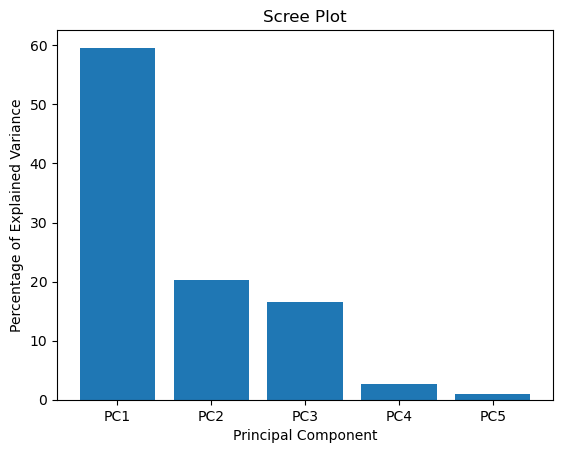

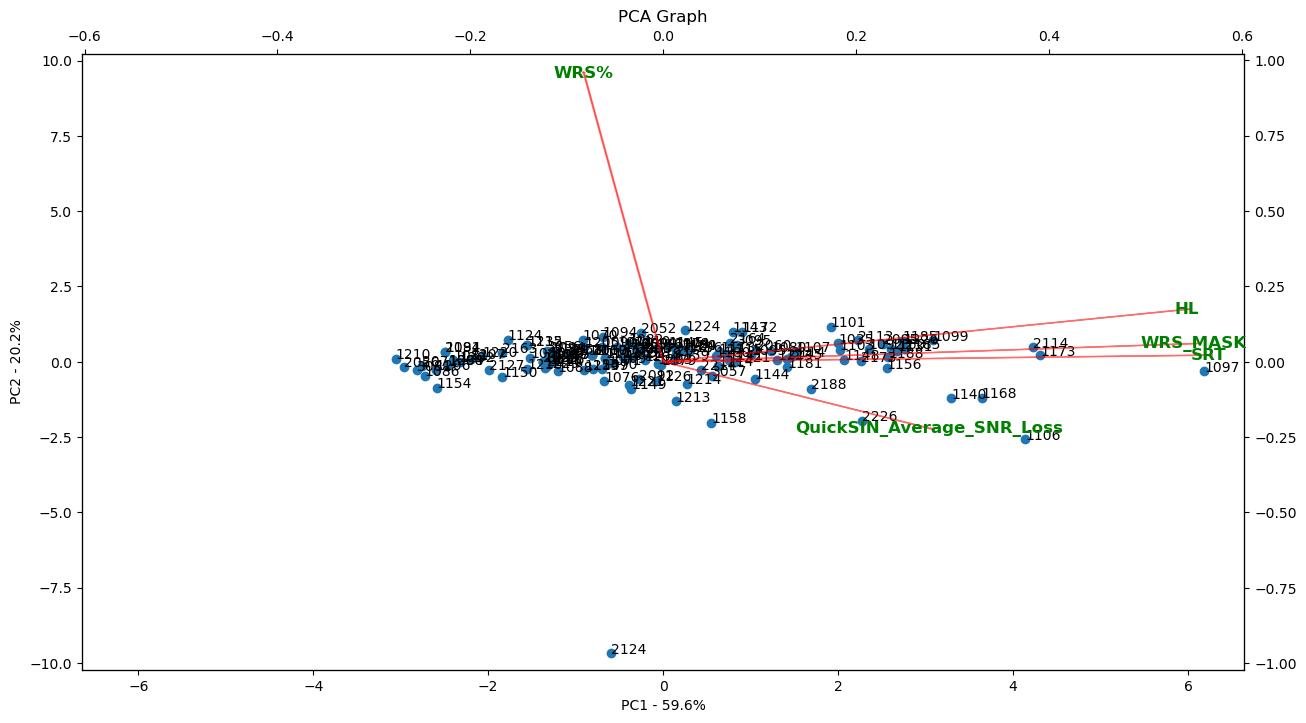


 3 PCs needed in order to explain 95.0% variation

                  PCA1_index       PC1                 PCA2_index       PC2  \
0                        SRT  0.565515                       WRS%  0.957649   
1                   WRS_MASK  0.549859  QuickSIN_Average_SNR_Loss -0.220607   
2                         HL  0.543057                         HL  0.173658   
3  QuickSIN_Average_SNR_Loss  0.275991                   WRS_MASK  0.060086   
4                       WRS% -0.082256                        SRT  0.021773   

                  PCA3_index       PC3  
0  QuickSIN_Average_SNR_Loss  0.932759  
1                       WRS%  0.247664  
2                   WRS_MASK -0.210186  
3                        SRT -0.126212  
4                         HL -0.092281  

 --- END PCA ---


 --- START K-MEANS 2 clusters ---

Silhouette score: 0.3996165721359342

 --- END K-MEANS 2 clusters ---


 --- START K-MEANS TUNING ---

Best k: 2
Best score: 0.39861163632741964

 --- END K-MEANS TUNING --

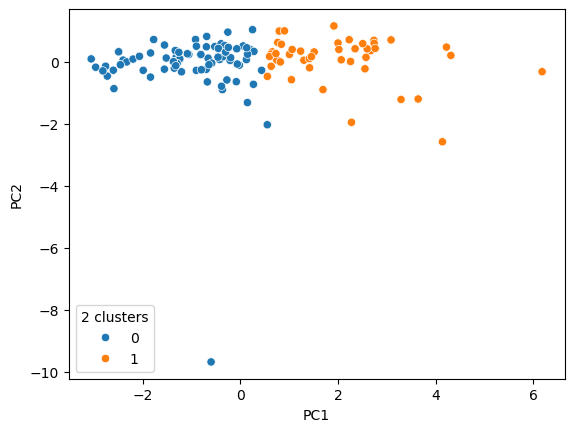

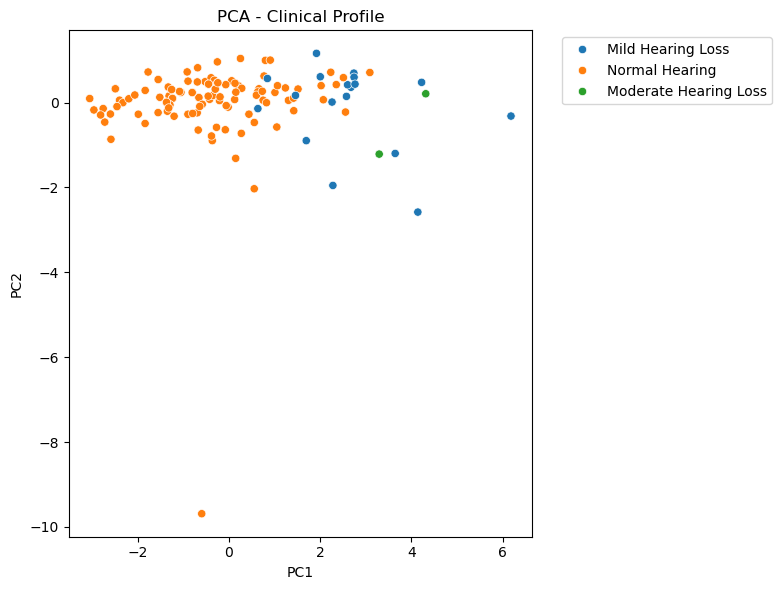

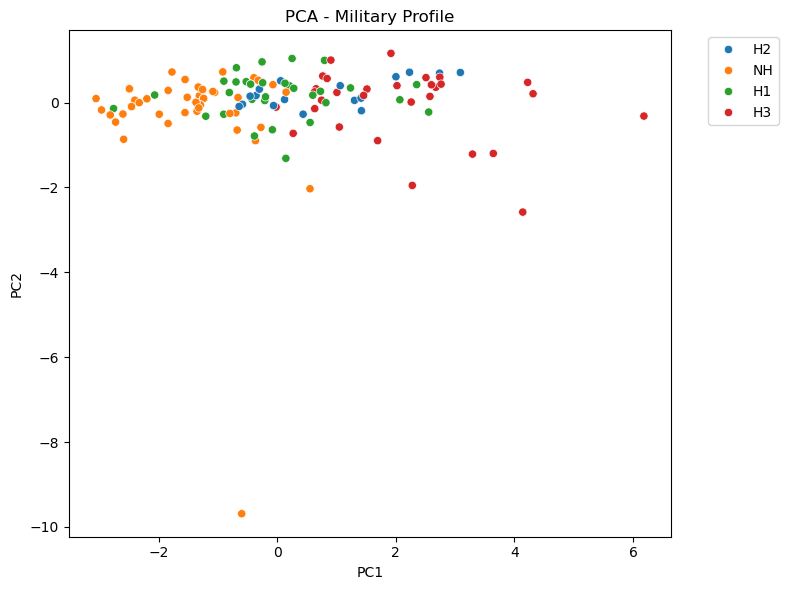

In [11]:
# Grab data and combine
data = load_data('../data/DOD_clinical_data.xlsx')
speech_df = data['Speech']

# Clean data
speech_df_cleaned = speech_df.set_index(speech_df['ID'])
speech_df_cleaned.drop(columns=['ID', 'Speech_Date', 'R_LIST', 'L_LIST', 'QuickSIN List 1', 'QuickSIN List 2', 'Notes'], inplace=True)

# Average between left and right (Note: The average between the integer 3 and None is 3)
# Note: R_WRS_MASK might have a space in the column name.
speech_df_averaged = speech_df_cleaned.copy()
keep = ["QuickSIN_Average_SNR_Loss"]
for column in speech_df_averaged: 
	if 'R_' in column and column not in keep:
		_, name = column.split('R_')
		speech_df_averaged[name] = average_columns(speech_df_averaged[column], speech_df_averaged['L_'+str(name)])

# Drop the original columns, leaving just the averages
speech_df_final = speech_df_averaged.drop(columns=list(set([*speech_df_cleaned.columns]) - set(keep)))
speech_df_final.dropna(inplace=True) 
print(f"Final data length: {len(speech_df_final)}")

# PCA Experimental Block
scaled_data, pca_df = principal_component_analysis(dataframe=speech_df_final, 
												   columns=speech_df_final.columns, 
												   n_components=len(speech_df_final.columns))
new_pca, score = k_means_clustering(k=2, scaled_data=scaled_data, pca_df=pca_df)
best_k, best_score = k_means_tuning(range(2, 8), scaled_data, pca_df)
graph_classification(pca_df)

# Tymp


 --- START PCA ---



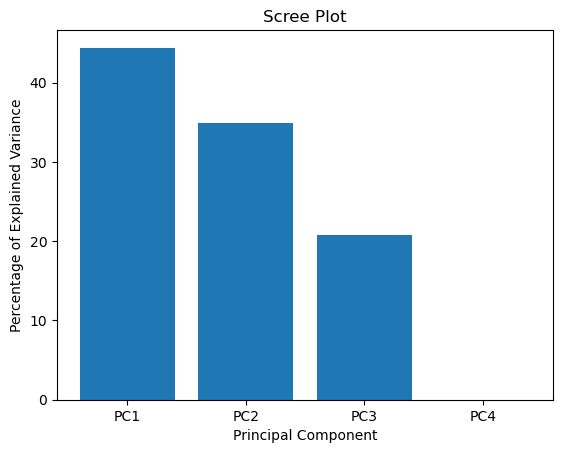

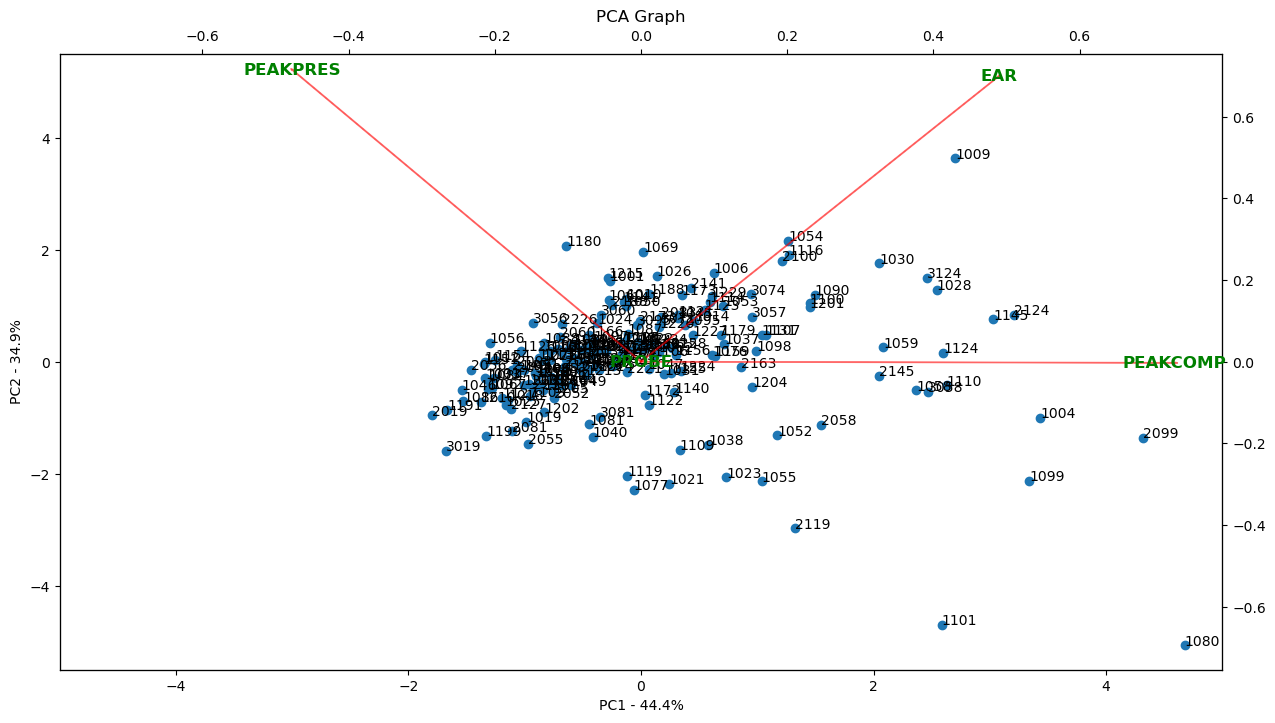


 3 PCs needed in order to explain 95.0% variation

  PCA1_index       PC1 PCA2_index       PC2 PCA3_index       PC3
0   PEAKCOMP  0.729973   PEAKPRES  0.714462   PEAKCOMP  0.683470
1        EAR  0.489725        EAR  0.699669        EAR -0.520224
2   PEAKPRES -0.476769   PEAKCOMP -0.002757   PEAKPRES  0.512090
3      PROBE  0.000000      PROBE -0.000000      PROBE  0.000000

 --- END PCA ---


 --- START K-MEANS 2 clusters ---

Silhouette score: 0.4851752452515704

 --- END K-MEANS 2 clusters ---


 --- START K-MEANS TUNING ---

Best k: 2
Best score: 0.44075011219208204

 --- END K-MEANS TUNING ---



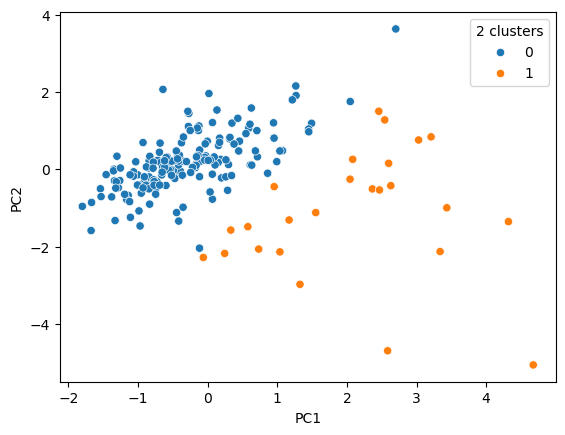

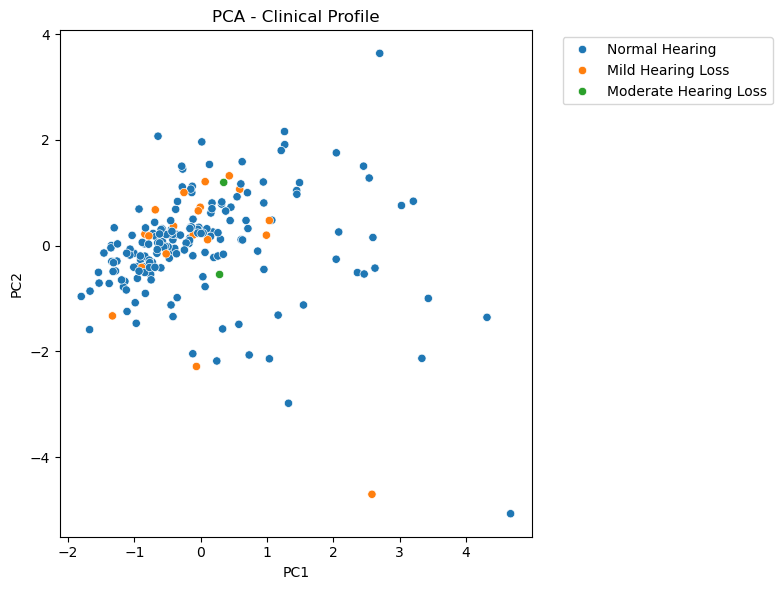

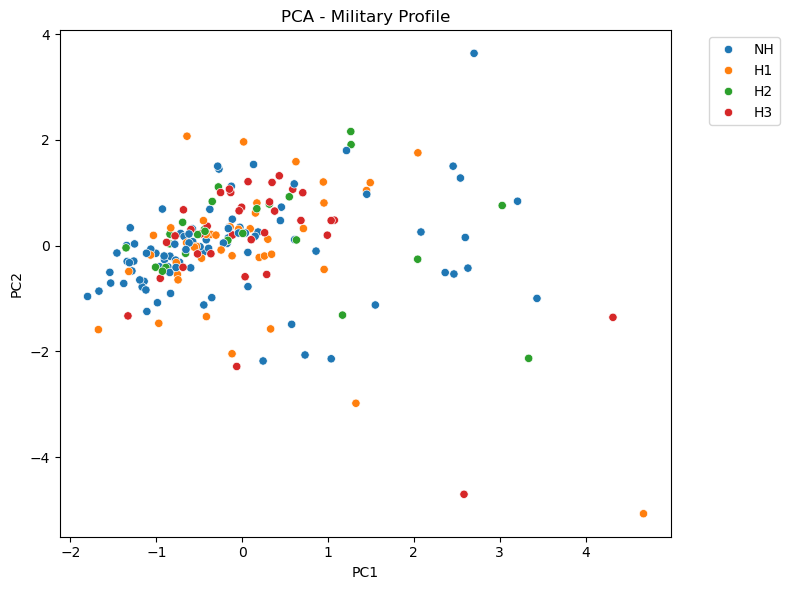

In [12]:
# Grab data and combine
data = load_data('../data/DOD_clinical_data.xlsx')
tymp = data['Tymp']

# Clean data
tymp_cleaned = tymp.set_index(tymp['ID']).drop(columns=['ID', 'Tymp_Date'])
tymp_cleaned = tymp_cleaned.dropna() # 193 after dropping NA values

# Average between left and right
tymp_averaged = tymp_cleaned.copy()
for column in tymp_averaged: 
	if 'TR_' in column and column not in keep:
		_, name = column.split('TR_')
		tymp_averaged[name] = average_columns(tymp_averaged[column], tymp_averaged['TL_'+str(name)])

# Drop the original columns, leaving just the averages
tymp_final = tymp_averaged.drop(columns=list(set([*tymp_cleaned.columns]) - set(keep)))

# PCA Experimental Block
scaled_data, pca_df = principal_component_analysis(dataframe=tymp_final, 
												   columns=tymp_final.columns, 
												   n_components=len(tymp_final.columns))
new_pca, score = k_means_clustering(k=2, scaled_data=scaled_data, pca_df=pca_df)
best_k, best_score = k_means_tuning(range(2, 8), scaled_data, pca_df)
graph_classification(pca_df)

Interpretation
- Peakpres, Ear, and Peakcomp are independent variables.

# AC_Reflex (wip)

Questions:
- abs, UdB, DNT, >100


 --- START PCA ---



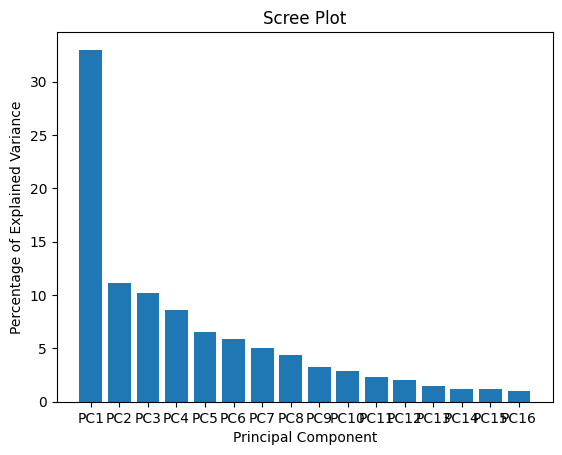

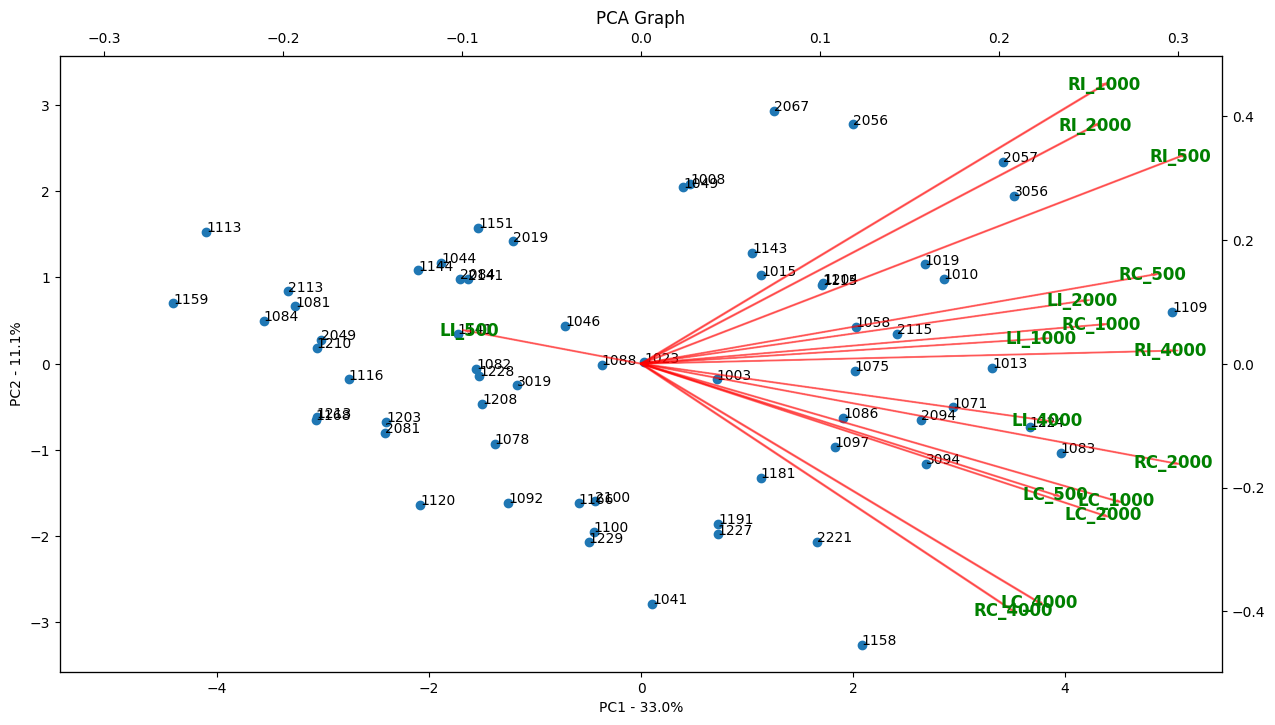


 12 PCs needed in order to explain 95.0% variation

   PCA1_index       PC1 PCA2_index       PC2 PCA3_index       PC3 PCA4_index  \
0      RI_500  0.301413    RI_1000  0.450861    RI_4000  0.388755    LI_1000   
1     RC_2000  0.297414    RC_4000 -0.399118    LC_4000  0.388154     RC_500   
2     RI_4000  0.295581    LC_4000 -0.385745    LC_1000 -0.360119    LI_2000   
3      RC_500  0.285589    RI_2000  0.385371     LC_500 -0.334427    RC_4000   
4     LC_1000  0.265136     RI_500  0.335278    LI_4000  0.312115    LC_2000   
5     RI_1000  0.258685    LC_2000 -0.244504     RC_500 -0.288052    RC_1000   
6     LC_2000  0.257891    LC_1000 -0.221363     LI_500  0.277192    LC_1000   
7     RC_1000  0.257062     LC_500 -0.211871    RC_1000 -0.261320    RI_4000   
8     RI_2000  0.253857    RC_2000 -0.160488    LI_2000  0.222198     RI_500   
9     LI_2000  0.246464     RC_500  0.143660    RI_2000  0.211914     LC_500   
10     LC_500  0.231147    LI_2000  0.101380    RC_2000 -0.154083  

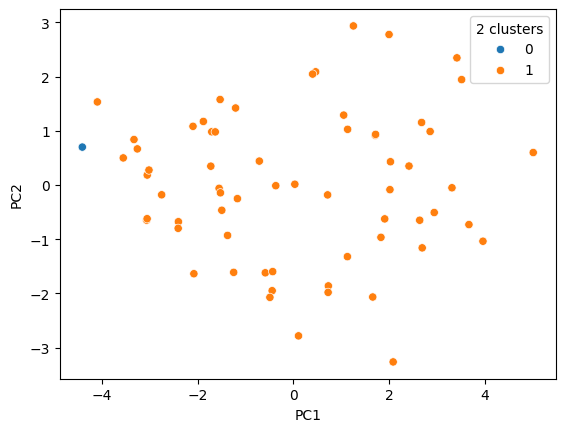

In [240]:
# Grab data and combine
data = load_data('../data/DOD_clinical_data.xlsx')
df = data['AC_Reflex']

# Clean data
df = df.set_index(df['ID']).drop(columns=['ID', 'AC_Reflex_Date'])
df = df.dropna() # 171 after dropping NA values

# PCA Experimental Block
scaled_data, pca_df = principal_component_analysis(dataframe=df, 
												   columns=df.columns, 
												   n_components=len(df.columns))
new_pca, score = k_means_clustering(k=2, scaled_data=scaled_data, pca_df=pca_df)
best_k, best_score = k_means_tuning(range(2, 8), scaled_data, pca_df)

Interpretations:

# DPOAE (wip)

3904

 --- START PCA ---



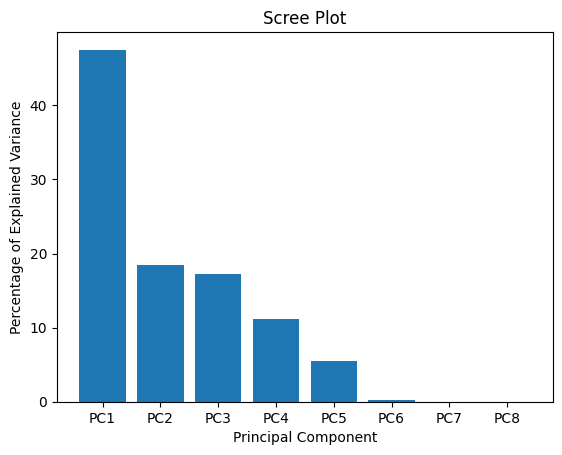

TypeError: cannot convert the series to <class 'float'>

<Figure size 1500x800 with 3 Axes>


 5 PCs needed in order to explain 95.0% variation

    PCA1_index           PC1   PCA2_index           PC2   PCA3_index  \
0           F1  4.977402e-01          SNR  6.832955e-01           L2   
1           F2  4.977402e-01     DP_level  3.793617e-01           L1   
2     DP_level -4.700482e-01           L1 -3.501805e-01          SNR   
3  Noise_Level -4.611787e-01           L2 -3.228902e-01     DP_level   
4          SNR -2.629343e-01           F2  2.403052e-01           F2   
5           L1 -3.776925e-02           F1  2.403052e-01           F1   
6           L2 -1.781279e-02  Noise_Level -2.163660e-01  Noise_Level   
7         f2F1 -2.775558e-17         f2F1  2.220446e-16         f2F1   

            PC3   PCA4_index           PC4   PCA5_index           PC5  
0  6.295709e-01           L2  7.062771e-01  Noise_Level  7.477246e-01  
1  6.111155e-01           L1 -7.039764e-01           F2  4.026325e-01  
2  3.462479e-01           F1 -4.210888e-02           F1  4.026325e-01  
3  1.992364

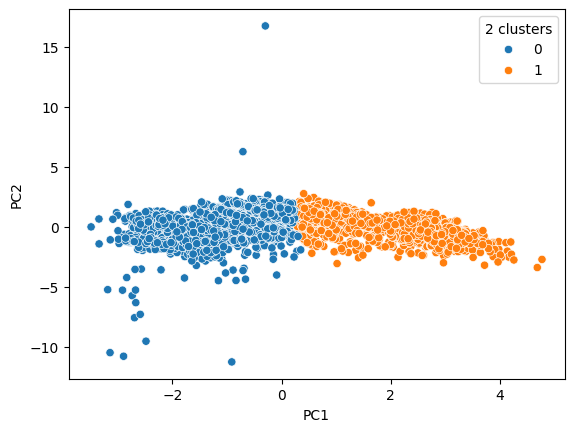

In [254]:
# Grab data and combine
data = load_data('../data/DOD_clinical_data.xlsx')
df = data['DPOAE']

# Clean data
df = df.set_index(df['ID'])
df = df[['F1', 'F2', 'f2F1', 'L1', 'L2', 'DP_level', 'Noise_Level', 'SNR']]
df = df.dropna() # 3904 after dropping NA values
df = df.replace({'P' : 0, 'F' : 1})
print(len(df))

# PCA Experimental Block
scaled_data, pca_df = principal_component_analysis(dataframe=df, 
												   columns=df.columns, 
												   n_components=len(df.columns))
new_pca, score = k_means_clustering(k=2, scaled_data=scaled_data, pca_df=pca_df)
best_k, best_score = k_means_tuning(range(2, 8), scaled_data, pca_df)

# Summary


 --- START PCA ---



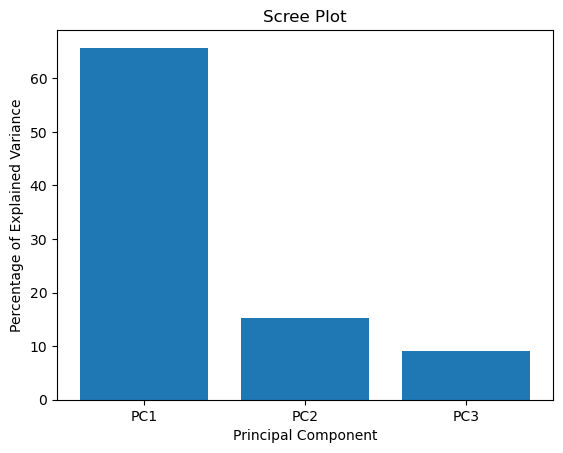

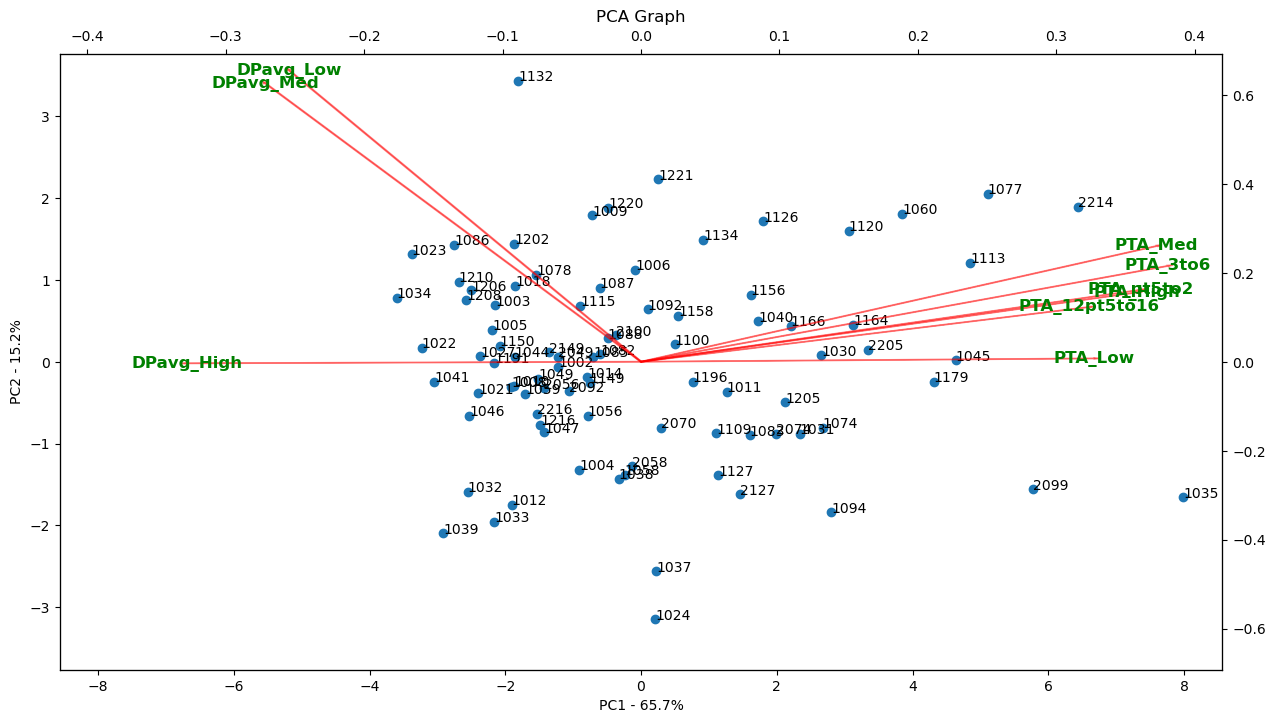


 3 PCs needed in order to explain 95.0% variation

      PCA1_index       PC1     PCA2_index       PC2     PCA3_index       PC3
0       PTA_3to6  0.380219      DPavg_Low  0.654983        PTA_Low  0.606621
1        PTA_Med  0.372598      DPavg_Med  0.625663  PTA_12pt5to16 -0.448191
2     PTA_pt5to2  0.361171        PTA_Med  0.260124     DPavg_High  0.409145
3       PTA_High  0.358266       PTA_3to6  0.215123     PTA_pt5to2  0.409056
4     DPavg_High -0.328318     PTA_pt5to2  0.161763       PTA_High -0.287331
5        PTA_Low  0.327192       PTA_High  0.155787        PTA_Med  0.116452
6  PTA_12pt5to16  0.323547  PTA_12pt5to16  0.122870       PTA_3to6 -0.015036
7      DPavg_Med -0.271354        PTA_Low  0.007397      DPavg_Med  0.007712
8      DPavg_Low -0.254249     DPavg_High -0.003589      DPavg_Low -0.001894

 --- END PCA ---


 --- START K-MEANS 2 clusters ---

Silhouette score: 0.4179871047203494

 --- END K-MEANS 2 clusters ---


 --- START K-MEANS TUNING ---

Best k: 2
Best score

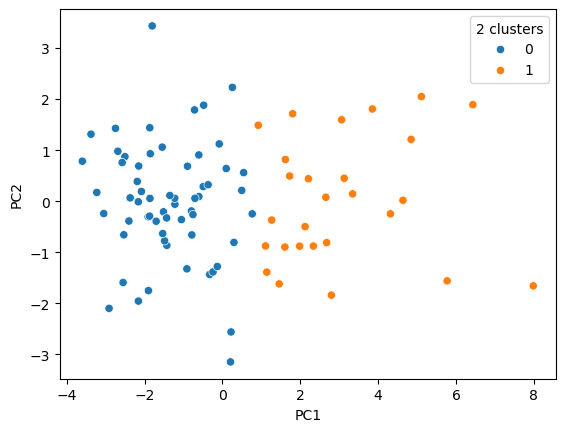

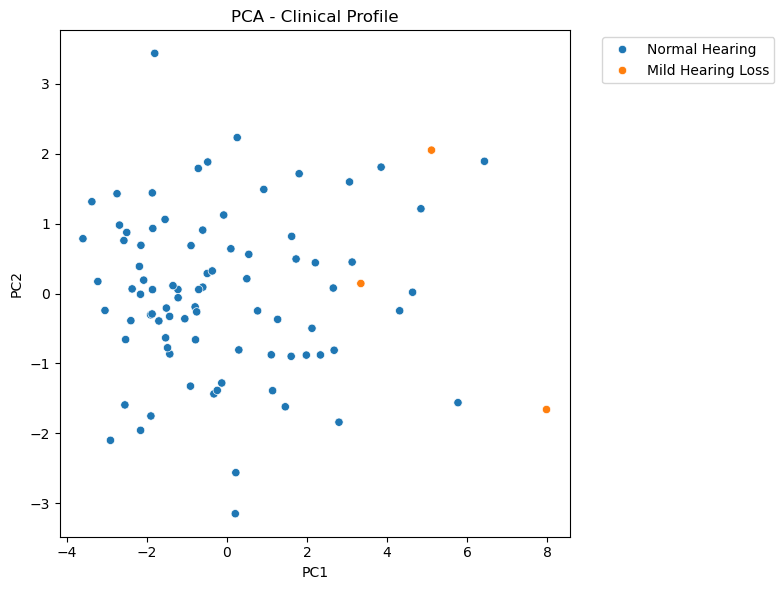

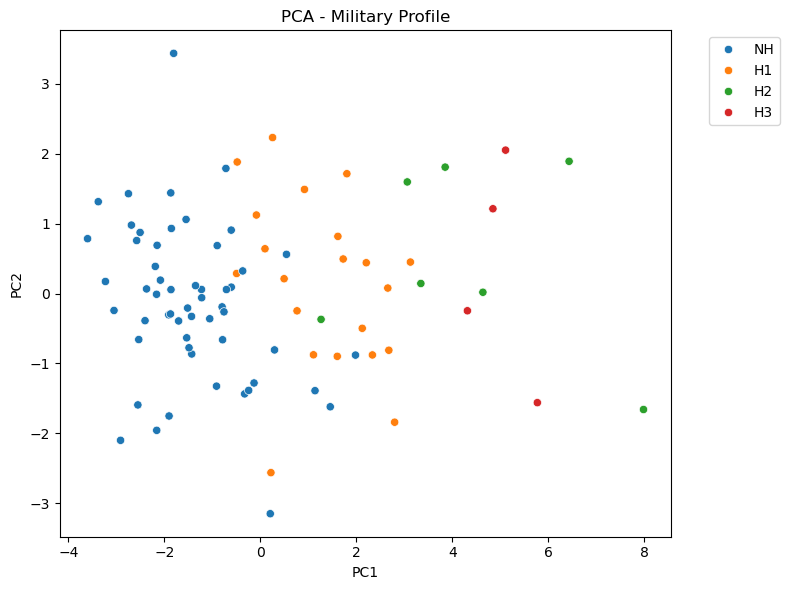

In [13]:
# Summary Experimental Block
data = load_data('../data/DOD_clinical_data.xlsx')

# Get our columns
columns = ['PTA_pt5to2', 'PTA_3to6', 'PTA_12pt5to16',
		   'PTA_Low', 'PTA_Med', 'PTA_High',
		   'DPavg_Low', 'DPavg_Med', 'DPavg_High']

scaled_data, pca_df = principal_component_analysis(dataframe=data['Summary'].set_index(data['Summary']['ID']), 
												   columns=columns, 
												   n_components=3)
new_pca, score = k_means_clustering(k=2, scaled_data=scaled_data, pca_df=pca_df)
best_k, best_score = k_means_tuning(range(2, 8), scaled_data, pca_df)
graph_classification(pca_df)

Now, let's include every variable we have into 1 single dataframe.

Final AirCon data length: 203
Final BoneCon data length: 203
Final Speech data length: 203
Final Tymp data length: 202
Final Summary data length: 185
Total data length: 105

 --- START PCA ---



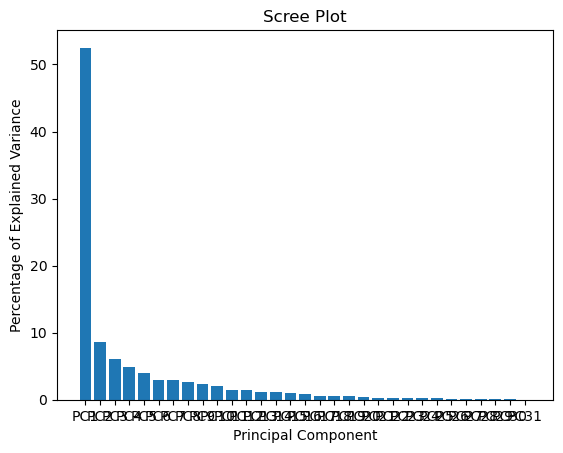

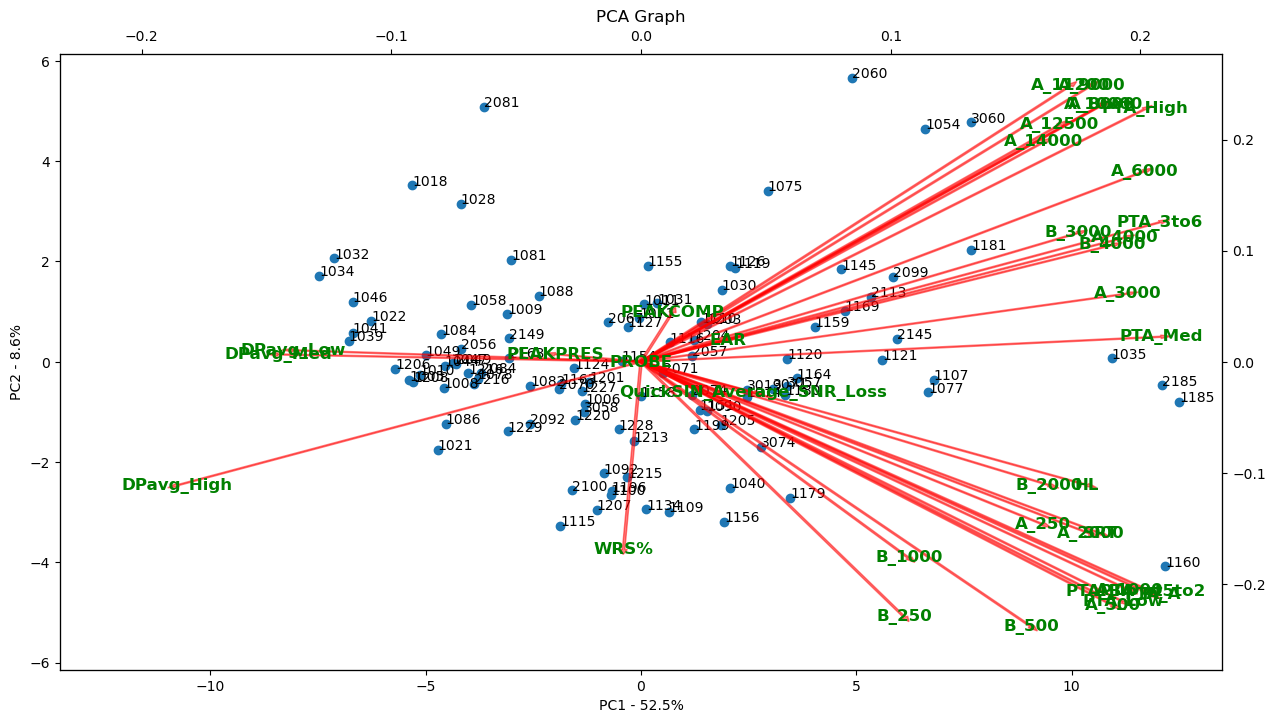


 15 PCs needed in order to explain 95.0% variation

                   PCA1_index       PC1                 PCA2_index  \
0                     PTA_Med  0.208172                     A_9000   
1                    PTA_3to6  0.207867                    A_11200   
2                  PTA_pt5to2  0.204963                      B_500   
3                       PTA_A  0.204821                    A_10000   
4                    PTA_High  0.201726                     A_8000   
5                      A_6000  0.201576                      B_250   
6                      A_1000  0.195784                   PTA_High   
7                      A_3000  0.194875                      A_500   
8                      A_4000  0.193901                    PTA_Low   
9                     PTA_Low  0.193217                    A_12500   
10                      A_500  0.189068                      PTA_A   
11                     B_4000  0.188889                 PTA_pt5to2   
12                 DPavg_High -0.1856

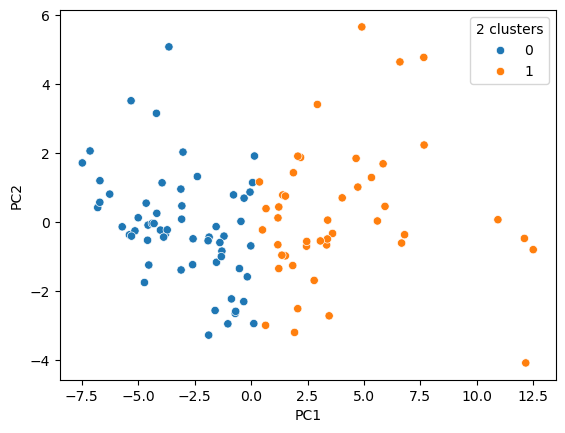

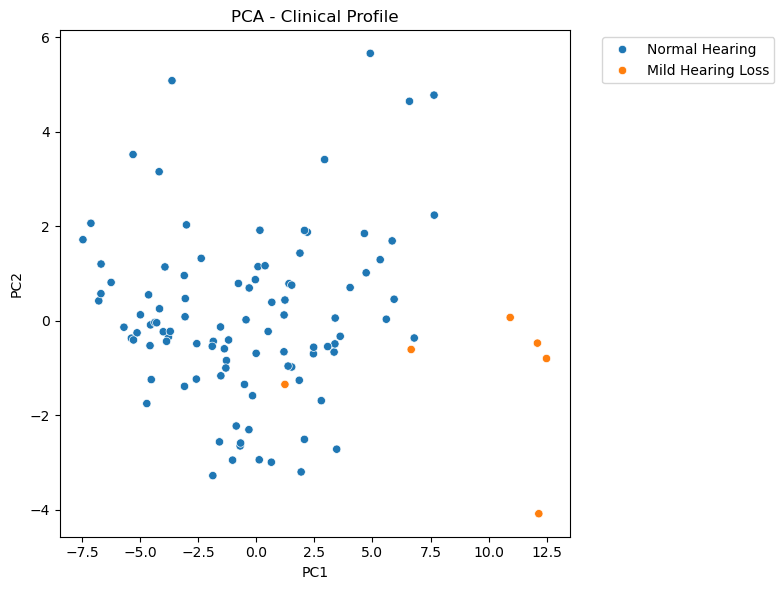

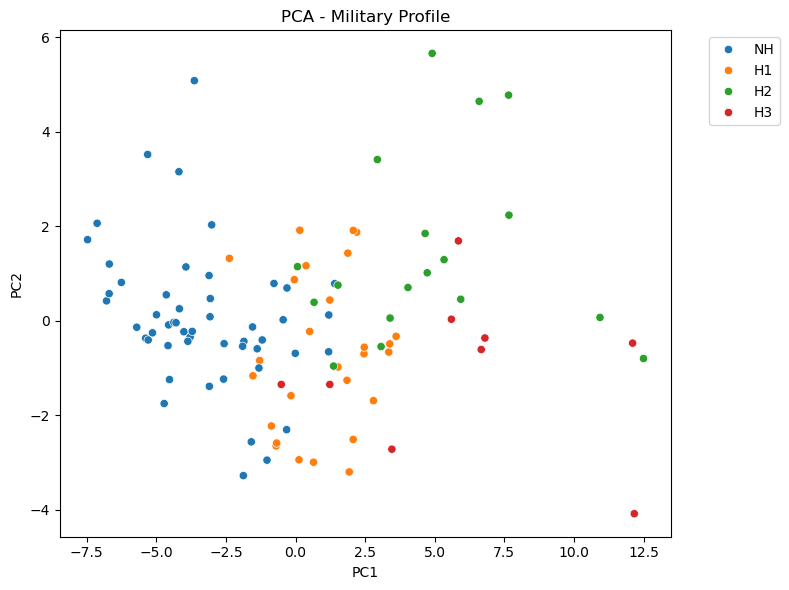

In [47]:
# Grab data and combine data/DOD_clinical_data.xlsx
data = load_data('../data/DOD_clinical_data.xlsx')
aircon_low_df = data['AirCon'].set_index(data['AirCon']['ID'])
aircon_high_df = data['AirConHigh'].set_index(data['AirConHigh']['ID'])
bonecon_df= data['BoneCon'].set_index(data['BoneCon']['ID'])
aircon_low_df = data['AirCon'].set_index(data['AirCon']['ID'])
speech_df = data['Speech'].set_index(data['Speech']['ID'])
tymp_df = data['Tymp'].set_index(data['Tymp']['ID'])
summary_df = data['Summary'].set_index(data['Summary']['ID'])
									
# Organize AirCon Data
# Note: If we removed all participants that had a DNC or NR reading, we will have 19 participants left. 
# Therefore, a better solution is to exclude the higher frequencies which have a whole lot more of those values.
aircon_high_df.drop(columns=['RU8000', 'LU8000'], inplace=True) # Redundant info
aircon_all_df = pd.concat([aircon_low_df, aircon_high_df], axis = 1)
aircon_all_df_cleaned = aircon_all_df.replace({"DNC" : None, "NR" : None})
aircon_all_df_cleaned.drop(columns=['RU16000', 'RU18000', 'RU20000', 'LU16000', 'LU18000', 'LU20000'], inplace=True)
# Average between left and right
aircon_all_df_averaged = aircon_all_df_cleaned.copy()
for column in aircon_all_df_averaged: 
	if 'RU' in column:
		right, frequency = column.split('U')
		aircon_all_df_averaged["A_"+frequency] = average_columns(aircon_all_df_averaged[column], aircon_all_df_averaged['LU'+str(frequency)])
aircon_all_df_averaged['PTA_A'] = average_columns(aircon_all_df_averaged['PTA_A_R'], aircon_all_df_averaged['PTA_A_L'])
# Drop the original columns, leaving just the averages
aircon_all_df_final = aircon_all_df_averaged.drop(columns=[*aircon_all_df_cleaned.columns])
# aircon_all_df.dropna(inplace=True)
print(f"Final AirCon data length: {len(aircon_all_df_final)}")

# Organize BoneCon data
keep = 'PTA_B_R	PTA_B_L	RU250	RU500	RU1000	RU2000	RU3000	RU4000	RU6000	RU8000	LU250	LU500	LU1000	LU2000	LU3000	LU4000	LU6000	LU8000'.split('\t')
bonecon_df_cleaned = bonecon_df.replace({"DNC" : None, "NR" : None})
bonecon_df_cleaned = bonecon_df_cleaned[keep] # Keep only unmasked data since mask doesn't have a lot of data.
bonecon_df_cleaned.drop(columns=['RU8000', 'LU8000', 'RU6000', 'LU6000'], inplace=True) # Also drop these because they're NA for mostly everyone.
# Average between left and right (Note: The average between the integer 3 and None is 3)
bonecon_df_averaged = bonecon_df_cleaned.copy()
for column in bonecon_df_averaged: 
	if 'RU' in column:
		right, frequency = column.split('U')
		bonecon_df_averaged["B_"+frequency] = average_columns(bonecon_df_averaged[column], bonecon_df_averaged['LU'+str(frequency)])
bonecon_df_averaged['PTA_B'] = average_columns(bonecon_df_averaged['PTA_B_R'], bonecon_df_averaged['PTA_B_L'])
# Drop the original columns, leaving just the averages
bonecon_df_final = bonecon_df_averaged.drop(columns=[*bonecon_df_cleaned.columns])
# bonecon_df_final.dropna(inplace=True) 
print(f"Final BoneCon data length: {len(bonecon_df_final)}")

# Organize Speech data
speech_df_cleaned = speech_df.drop(columns=['ID', 'Speech_Date', 'R_LIST', 'L_LIST', 'QuickSIN List 1', 'QuickSIN List 2', 'Notes'])
# Average between left and right (Note: The average between the integer 3 and None is 3)
# Note: R_WRS_MASK might have a space in the column name.
speech_df_averaged = speech_df_cleaned.copy()
keep = ["QuickSIN_Average_SNR_Loss"]
for column in speech_df_averaged: 
	if 'R_' in column and column not in keep:
		_, name = column.split('R_')
		speech_df_averaged[name] = average_columns(speech_df_averaged[column], speech_df_averaged['L_'+str(name)])
# Drop the original columns, leaving just the averages
speech_df_final = speech_df_averaged.drop(columns=list(set([*speech_df_cleaned.columns]) - set(keep)))
# speech_df_final.dropna(inplace=True) 
print(f"Final Speech data length: {len(speech_df_final)}")

# Organize Tymp data
tymp_df_cleaned = tymp_df.drop(columns=['ID', 'Tymp_Date'])
# Average between left and right
tymp_df_averaged = tymp_df_cleaned.copy()
for column in tymp_df_averaged: 
	if 'TR_' in column and column not in keep:
		_, name = column.split('TR_')
		tymp_df_averaged[name] = average_columns(tymp_df_averaged[column], tymp_df_averaged['TL_'+str(name)])
# Drop the original columns, leaving just the averages
tymp_df_final = tymp_df_averaged.drop(columns=list(set([*tymp_df_cleaned.columns]) - set(keep)))
# tymp_df_final.dropna(inplace=True) # 193 after dropping NA values
print(f"Final Tymp data length: {len(tymp_df_final)}")

# Organize Summary data
summary_df_columns = ['PTA_pt5to2', 'PTA_3to6', 'PTA_12pt5to16',
		   'PTA_Low', 'PTA_Med', 'PTA_High',
		   'DPavg_Low', 'DPavg_Med', 'DPavg_High']
summary_df_final = summary_df[columns]
print(f"Final Summary data length: {len(summary_df_final)}")

# Combine all dataframes
all_df = pd.concat([aircon_all_df_final, bonecon_df_final, speech_df_final, tymp_df_final, summary_df_final], axis = 1)
# na_counts = all_df.isna().sum()
# print(na_counts)
drop_columns = ["WRS_MASK", "PTA_12pt5to16"] # Some columns that have a lot of NA values
all_df.drop(columns=drop_columns, inplace=True)
print(f"Total data length: {len(all_df.dropna())}")

# Run PCA functions
scaled_data, pca_df = principal_component_analysis(dataframe=all_df, 
												   columns=all_df.columns, 
												   n_components=31) # Arbitary max
new_pca, score = k_means_clustering(k=2, scaled_data=scaled_data, pca_df=pca_df)
best_k, best_score = k_means_tuning(range(2, 8), scaled_data, pca_df)
graph_classification(pca_df)

# Brett's Theoretically Salient Variables

Informative Variables:
- Summary & AirCon: PTA LOW PTA MED PTA HIGH & DP AVG LOW DP AVG MED DP AVG HIGH
- Speech: SRT_RIGHT SRT_LEFT (AVGED), QUICKSIN AVG
- Tymp: Peak compliance and Peak pressure

In [ ]:
# Grab data and combine
data = load_data('../data/DOD_clinical_data.xlsx')
summary_df = data['Summary']
speech_df = data['Speech']
tymp_df = data['Tymp']


...

# Summary Experimental Block
scaled_data, pca_df = principal_component_analysis(dataframe=all, 
												   columns=all.columns, 
												   n_components=len(all.columns))
new_pca, score = k_means_clustering(k=2, scaled_data=scaled_data, pca_df=pca_df)
best_k, best_score = k_means_tuning(range(2, 8), scaled_data, pca_df)